<a href="https://colab.research.google.com/github/PiyushPranto/AI-Machine-Learning-Project/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Shape: (920, 16)

Column Types:
 id            int64
age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
num           int64
dtype: object

Class Distribution:
target
1    509
0    411
Name: count, dtype: int64


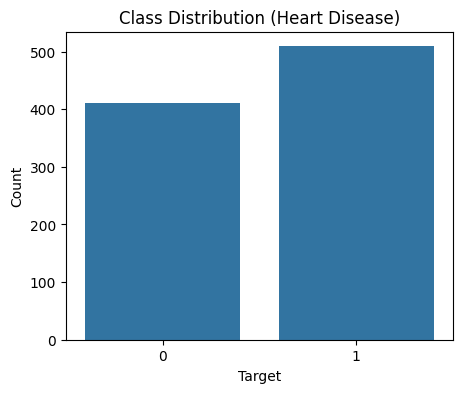

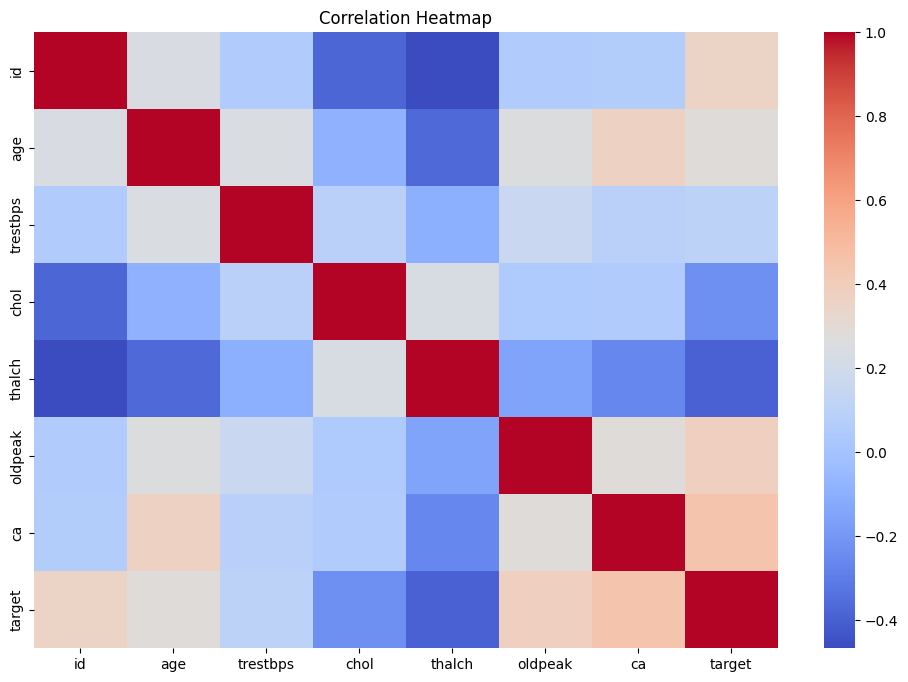

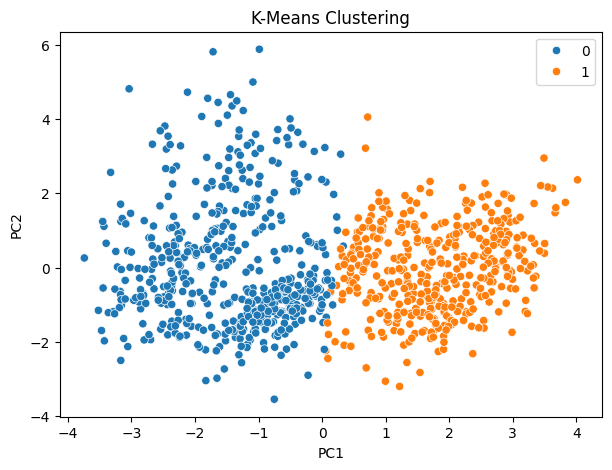


Model Accuracy:
Logistic Regression: 0.8641
KNN: 0.8261
Neural Network: 0.8261


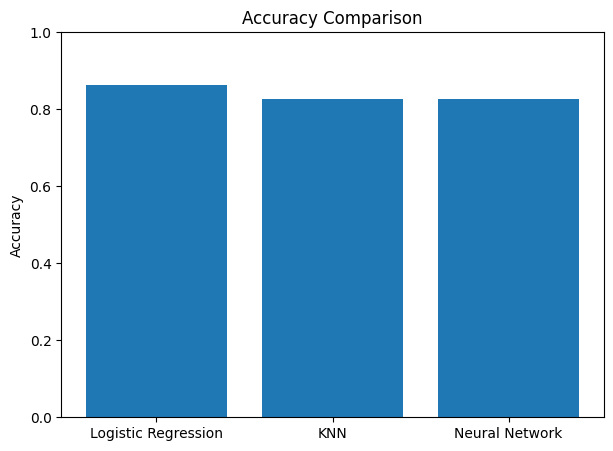

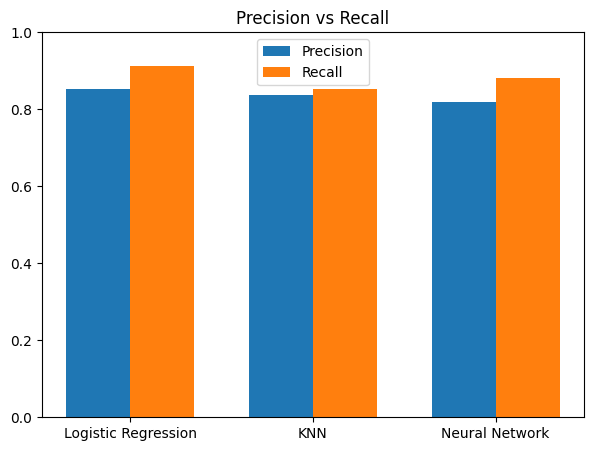


Best Model: Logistic Regression


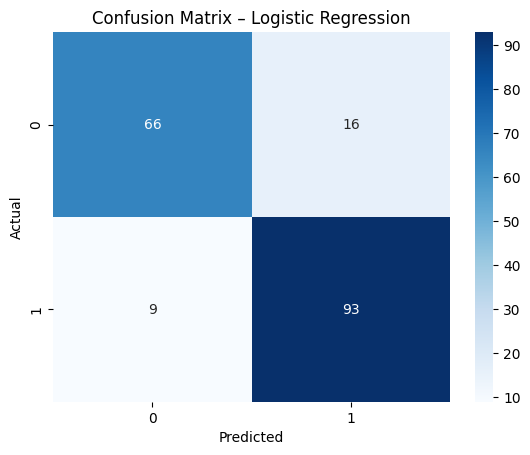


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.87      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



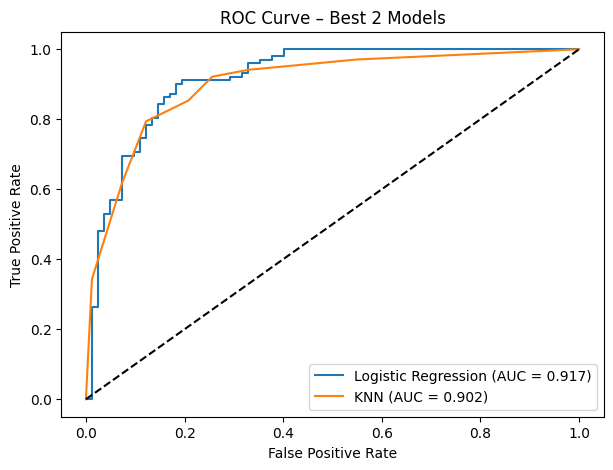

In [ ]:
# 1. IMPORT LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve


# 2. LOAD DATA

df = pd.read_csv("heart_disease.csv")

print("Dataset Shape:", df.shape)
print("\nColumn Types:\n", df.dtypes)


# 3. TARGET ENGINEERING


# Binary classification
df['target'] = df['num'].apply(lambda x: 0 if x == 0 else 1)
df.drop(columns=['num'], inplace=True)

print("\nClass Distribution:")
print(df['target'].value_counts())


# 4. EDA


plt.figure(figsize=(5,4))
sns.countplot(x=df['target'])
plt.title("Class Distribution (Heart Disease)")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


# 5. DATA PREPROCESSING


X = df.drop(columns=['target'])
y = df['target']

num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(include='object').columns

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

X[num_cols] = num_imputer.fit_transform(X[num_cols])
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# 6. DATASET SPLITTING (STRATIFIED)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# 7. UNSUPERVISED LEARNING – KMEANS

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters)
plt.title("K-Means Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


# 8. SUPERVISED MODELS (NEURAL NETWORK + 2 OTHERS)


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Neural Network": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        max_iter=1500,
        random_state=42
    )
}

accuracy = {}
precision = {}
recall = {}
predictions = {}
probabilities = {}

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    predictions[name] = y_pred
    probabilities[name] = y_prob

    accuracy[name] = accuracy_score(y_test, y_pred)
    precision[name] = precision_score(y_test, y_pred)
    recall[name] = recall_score(y_test, y_pred)


# 9. MODEL ACCURACY & METRICS (OUTPUT)

print("\nModel Accuracy:")
for model, acc in accuracy.items():
    print(f"{model}: {acc:.4f}")

plt.figure(figsize=(7,5))
plt.bar(accuracy.keys(), accuracy.values())
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.ylim(0,1)
plt.show()

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(7,5))
plt.bar(x - width/2, precision.values(), width, label='Precision')
plt.bar(x + width/2, recall.values(), width, label='Recall')
plt.xticks(x, models.keys())
plt.legend()
plt.ylim(0,1)
plt.title("Precision vs Recall")
plt.show()


# 10. CONFUSION MATRIX (BEST MODEL)

best_model = max(accuracy, key=accuracy.get)
print("\nBest Model:", best_model)

sns.heatmap(
    confusion_matrix(y_test, predictions[best_model]),
    annot=True,
    fmt='d',
    cmap='Blues'
)
plt.title(f"Confusion Matrix – {best_model}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, predictions[best_model]))


# 11. ROC CURVE (FIXED – ONLY 2 CURVES: BEST 2 MODELS)


top_2_models = sorted(accuracy, key=accuracy.get, reverse=True)[:2]

plt.figure(figsize=(7,5))

for name in top_2_models:
    fpr, tpr, _ = roc_curve(y_test, probabilities[name])
    auc_score = roc_auc_score(y_test, probabilities[name])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Best 2 Models")
plt.legend()
plt.show()
